# Homework 2

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology` and
- the market data file `market_prices_eod`.


# Problem 1: Constructing fixed rate bonds

In [353]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt

# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

## a. Prepare common symbology dataframe for fixed rate government and corporate bonds

Load the `govt_symbology` and `corp_symbology` Excel files into one common dataframe, using the `corp_symbology` columns. Filter the dataframe and keep fixed rate bonds only: (cpn_type="FIXED").


In [354]:
govt_symbology = pd.read_excel("/Users/zhenyuwang/Library/Mobile Documents/com~apple~CloudDocs/U Chicago/Git/credit_markets/HW2/govt_symbology.xlsx")
corp_symbology = pd.read_excel("/Users/zhenyuwang/Library/Mobile Documents/com~apple~CloudDocs/U Chicago/Git/credit_markets/HW2/corp_symbology.xlsx")

In [355]:
govt_and_corp = pd.concat([govt_symbology, corp_symbology], ignore_index= True)
fixed_govt_and_corp = govt_and_corp[govt_and_corp['cpn_type'] == 'FIXED'].reset_index()

## b. Add function to construct generic fixed rate cashflow schedules from symbology data

Use one row of the symbology dataframe as input  to the function. Use the helper function to convert a date string to a QuantLib date object.

In [356]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

In [357]:
def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])   # use date helper function and update code !!!
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])   # use date helper function and update code !!!
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

## c. Add function to construct generic fixed rate bond objects from symbology data

Use one row of the symbology dataframe as input to the function. Use create_schedule_from_symbology() internally to create the cashflow schedule.

In [358]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    if details['class'] == 'Govt':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    else:    
        day_count = ql.Thirty360(ql.Thirty360.USA)   # update code depending on dcc !!!
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])     # use date helper function and update code !!!
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


## d. Add function that returns a dataframe with (future) cash flows details for a bond object

Use the "Investigate Bond Cashflows" section in the Quantlib introductory notebook as a template.

The results dataframe should contain following columns:


| CashFlowDate | CashFlowAmount | CashFlowYearFrac |
|----------|-------|-------------|

Pick one government and one corporate bond from symbology, create the bond objects and display the future cashflows.

In [359]:
def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date) -> pd.DataFrame:
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    x = [(cf.date(), cf.amount()) for cf in bond.cashflows()]
    cf_date, cf_amount = zip(*x)
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date, 'CashFlowAmount': cf_amount})
    cashflows_df = cashflows_df[cashflows_df['CashFlowDate'] >= calc_date]
    day_counter = bond.dayCounter()

 
    discount_yearfrac = np.zeros((len(cashflows_df)))

    i = 0
    for cf_date in cashflows_df['CashFlowDate']:
        discount_yearfrac[i] = day_counter.yearFraction(calc_date, cf_date)
        i += 1

    cashflows_df['CashFlowYearFrac'] = discount_yearfrac

    
    return cashflows_df

In [360]:
get_bond_cashflows(create_bond_from_symbology(fixed_govt_and_corp[fixed_govt_and_corp['isin']=="US912810EQ77"].squeeze()),calc_date)

,CashFlowDate,CashFlowAmount,CashFlowYearFrac
59,"August 15th, 2023",3.125,0.333333
60,"August 15th, 2023",100.000,0.333333


In [361]:
get_bond_cashflows(create_bond_from_symbology(fixed_govt_and_corp[fixed_govt_and_corp['isin']=="US92346MJT99"].squeeze()),calc_date)

,CashFlowDate,CashFlowAmount,CashFlowYearFrac
1,"May 15th, 2023",2.075,0.086111
2,"November 15th, 2023",2.075,0.586111
3,"May 15th, 2024",2.075,1.086111
4,"November 15th, 2024",2.075,1.586111
5,"May 15th, 2025",2.075,2.086111
6,"November 15th, 2025",2.075,2.586111
7,"May 15th, 2026",2.075,3.086111
8,"November 15th, 2026",2.075,3.586111
9,"May 15th, 2027",2.075,4.086111
10,"November 15th, 2027",2.075,4.586111


# Problem 2: US Treasury yield curve calibration (On-The-Runs)

## a. Create the on-the-run US treasury bond objects

Restrict the symbology + market data dataframe to on-the-run US treasury notes only (excluding Treasury Bills) and create the treasury bond objects.

Extend the treasuries symbology dataframe with the following market data columns (code from Homework 1):


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

In [362]:
govt_symbology['term'] = (govt_symbology['maturity'] - govt_symbology['start_date']).dt.days/365.25
govt_symbology['current_date'] = dt.datetime(2023,4,14)
govt_symbology['TTM'] = (govt_symbology['maturity'] - govt_symbology['current_date']).dt.days/365.25

govt_on_the_run = pd.read_excel("/Users/zhenyuwang/Library/Mobile Documents/com~apple~CloudDocs/U Chicago/Git/credit_markets/HW2/govt_on_the_run.xlsx")
govt_on_the_run_only = govt_on_the_run[~govt_on_the_run['ticker'].str.contains('B|C')]
govt_on_the_run_only_symbology = govt_symbology[govt_symbology['isin'].isin(govt_on_the_run_only['isin'])]

In [363]:
market_prices = pd.read_excel("/Users/zhenyuwang/Library/Mobile Documents/com~apple~CloudDocs/U Chicago/Git/credit_markets/HW2/market_prices_eod.xlsx")
market_prices['mid_yield'] =( market_prices['bid_yield'] + market_prices['ask_yield'])/2
govt_yield = govt_on_the_run_only_symbology.merge(market_prices[['figi','date','bid','ask','mid_clean','mid_dirty',"bid_yield" , "ask_yield",'mid_yield']], how = 'left',on = 'figi')
govt_yield = govt_yield.sort_values(['TTM'])
for i in range(0, len(govt_yield)):
    row = govt_yield.loc[i]
    bond = create_bond_from_symbology(row)
    govt_yield.loc[i,'bond'] = bond
govt_yield

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,TTM,date,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield,mid_yield,bond
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,1.963039,2023-04-14,99.5703,99.5820,99.5762,99.7559,4.105,4.099,4.1020,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.750,FIXED,...,3.003422,2023-04-14,99.7578,99.7734,99.7656,99.7852,3.836,3.831,3.8335,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,4.963723,2023-04-14,100.0703,100.0859,100.0781,100.2461,3.609,3.606,3.6075,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,6.962355,2023-04-14,100.3750,100.4375,100.4063,100.5742,3.563,3.553,3.5580,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.500,FIXED,...,9.842574,2023-04-14,99.8438,99.8906,99.8672,100.4570,3.519,3.513,3.5160,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,19.841205,2023-04-14,100.2969,100.3750,100.3359,100.9883,3.853,3.847,3.8500,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,29.842574,2023-04-14,97.9531,98.0313,97.9922,98.6035,3.739,3.735,3.7370,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...


## b. Calibrate the on-the-run treasury yield curve (bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. Calibrate the bid, ask and mid discount factor curves as of 2023-04-14.

In [364]:
def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve

In [365]:
bid_curve = calibrate_yield_curve_from_frame(calc_date, govt_yield,'bid')
ask_curve = calibrate_yield_curve_from_frame(calc_date, govt_yield,'ask')
mid_curve = calibrate_yield_curve_from_frame(calc_date, govt_yield,'mid_clean')

In [366]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df


In [367]:
grid_dates = [mid_curve.referenceDate() + ql.Period(y, ql.Months) for y in list(range(0,366,6))]
govt_yield_curve_details_df = get_yield_curve_details_df(mid_curve, grid_dates)    # using external grid
print(govt_yield_curve_details_df)

          Date  YearFrac  DiscountFactor  ZeroRate
0   2023-04-14       0.0           1.000     4.233
1   2023-10-14       0.5           0.980     4.222
2   2024-04-14       1.0           0.960     4.189
3   2024-10-14       1.5           0.941     4.135
4   2025-04-14       2.0           0.924     4.058
..         ...       ...             ...       ...
56  2051-04-14      28.0           0.352     3.804
57  2051-10-14      28.5           0.346     3.789
58  2052-04-14      29.0           0.341     3.775
59  2052-10-14      29.5           0.337     3.760
60  2053-04-14      30.0           0.332     3.746

[61 rows x 4 columns]


## c. Plot the calibrated US Treasury yield (zero rate) curves

Create a graph/scatter plot of the newly computed mid yields by maturity.

<Axes: xlabel='YearFrac'>

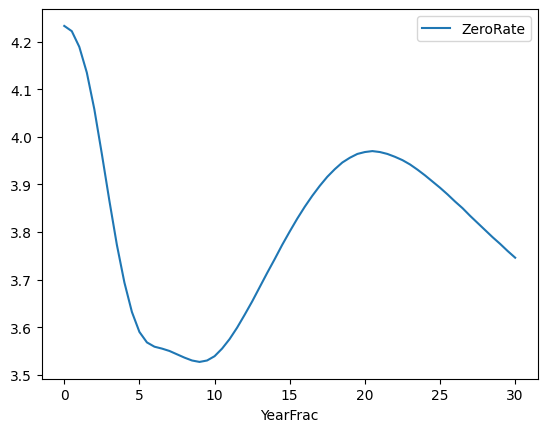

In [368]:
govt_yield_curve_details_df.plot(x="YearFrac",y="ZeroRate")

## d. Plot calibrated discount factors

Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.

<Axes: xlabel='YearFrac'>

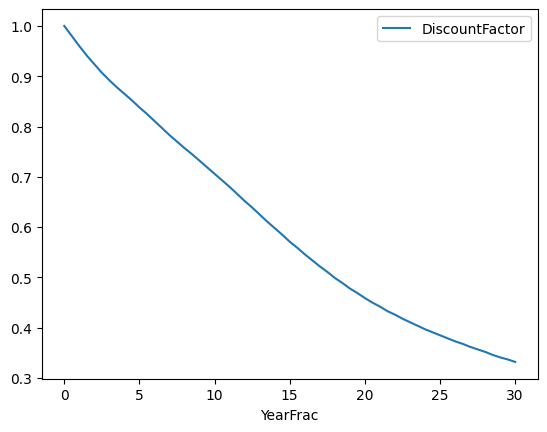

In [369]:
govt_yield_curve_details_df.plot(x="YearFrac",y="DiscountFactor")

# Problem 3: Pricing and risk metrics for US Treasury bonds

## a. US Treasury pricing on the calibrated discount factor curve

Follow Section 5. "Present Value Calculation (no credit risk)" in the QuantLib introductory notebook to re-price the US on-the-run treasuries using the calibrated discount factor curve. 

You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)

Extend the dataframe with the following computed columns for clean mid prices:


| calc_mid |
|---------------|


To validate the calibration, compare the calculated clean mid prices to the original market mid prices.

In [379]:
treasury_yield_curve_mid_handle = ql.YieldTermStructureHandle(mid_curve)
bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)
govt_yield['calc_mid'] = np.zeros(len(govt_yield))
for i in range(0, len(govt_yield)):
    row = govt_yield.loc[i]
    bond = row['bond']
    bond.setPricingEngine(bond_engine)
    pv_engine = bond.NPV()
    govt_yield.loc[i, 'calc_mid'] = pv_engine

govt_yield['diff_calc_market_mid'] = govt_yield['calc_mid'] - govt_yield['mid_clean']

govt_yield
    

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,mid_yield,bond,calc_mid,diff_calc_market_mid,duration,convexity,dv01,scen_dv01,scen_duration,scen_convexity
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,4.1020,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,99.722292,0.146092,1.850297,4.386755,1.845781,1.9309,1.9356,3.8089
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.750,FIXED,...,3.8335,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,99.752188,-0.013412,2.787303,9.353226,2.781316,2.8516,2.8577,8.3946
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,3.6075,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.212414,0.134314,4.445470,22.999615,4.456410,4.6250,4.6136,22.3487
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,3.5580,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.540502,0.134202,6.008350,41.925992,6.042850,6.2818,6.2459,41.8547
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.500,FIXED,...,3.5160,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.422847,0.555647,8.036846,76.334006,8.073575,8.3965,8.3583,77.4490
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,3.8500,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.954557,0.618657,13.066188,224.427402,13.195321,14.0089,13.8717,239.4788
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,3.7370,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,98.569540,0.577340,16.386325,387.768447,16.157490,17.9689,18.2235,446.6779


The calculated price and the market price do not exactly match. This indicates that the fitted curve does not exactly pass through the yield data points of these 7 on the run Treasuries.

## b. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield)

Compute analytical DV01, Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration. 

Extend the dataframe with the following calculated risk metrics:


| dv01 | duration | convexity |
|-------|-------|-------------|


In [371]:
flat_rate = ql.SimpleQuote(0.05)
rate_handle = ql.QuoteHandle(flat_rate)
day_count = ql.ActualActual(ql.ActualActual.ISMA)
compounding = ql.Compounded
coupon_freq = ql.Semiannual

flat_int_rate = ql.InterestRate(flat_rate.value(), day_count, compounding, coupon_freq)

govt_yield['duration'] = np.zeros(len(govt_yield))

govt_yield['convexity'] = np.zeros(len(govt_yield))


for i in govt_yield.index:
    fixed_rate_bond = govt_yield.loc[i,'bond']
    bond_duration = ql.BondFunctions.duration(fixed_rate_bond, flat_int_rate)
    bond_convexity = ql.BondFunctions.convexity(fixed_rate_bond, flat_int_rate)
    govt_yield.loc[i,'duration'] = bond_duration
    govt_yield.loc[i,'convexity'] = bond_convexity

govt_yield['dv01'] = govt_yield['duration'] * govt_yield["mid_dirty"]/100

govt_yield


,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,mid_dirty,bid_yield,ask_yield,mid_yield,bond,calc_mid,diff_calc_market_mid,duration,convexity,dv01
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,99.7559,4.105,4.099,4.1020,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,99.722292,0.146092,1.850297,4.386755,1.845781
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.750,FIXED,...,99.7852,3.836,3.831,3.8335,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,99.752188,-0.013412,2.787303,9.353226,2.781316
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,100.2461,3.609,3.606,3.6075,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.212414,0.134314,4.445470,22.999615,4.456410
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,100.5742,3.563,3.553,3.5580,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.540502,0.134202,6.008350,41.925992,6.042850
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.500,FIXED,...,100.4570,3.519,3.513,3.5160,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.422847,0.555647,8.036846,76.334006,8.073575
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,100.9883,3.853,3.847,3.8500,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.954557,0.618657,13.066188,224.427402,13.195321
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,98.6035,3.739,3.735,3.7370,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,98.569540,0.577340,16.386325,387.768447,16.157490


## c. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

Compute the scenario DV01, Duration and Convexity metrics using +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration.

Extend the dataframe with the following scenario sensitivities metrics:

| scen_dv01 | scen_duration | scen_convexity |
|-------|-------|-------------|



In [372]:
# start with interest_rate_bump = 0
mid_yield_curve_handle = ql.YieldTermStructureHandle(mid_curve)
interest_rate_bump = ql.SimpleQuote(0.0)
mid_yield_curve_handle_bumped = ql.ZeroSpreadedTermStructure(mid_yield_curve_handle, ql.QuoteHandle(interest_rate_bump))

bond_engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(mid_yield_curve_handle_bumped))

govt_yield['scen_dv01'] = np.zeros(len(govt_yield))
govt_yield['scen_duration'] = np.zeros(len(govt_yield))
govt_yield['scen_convexity'] = np.zeros(len(govt_yield))

for i in govt_yield.index:
    fixed_rate_bond = govt_yield.loc[i,'bond']
    fixed_rate_bond.setPricingEngine(bond_engine)

    price_base = fixed_rate_bond.cleanPrice()


    # Bump interest rate by +1bps (parallel shift)
    interest_rate_bump.setValue(0.0001)
    price_up_1bp = fixed_rate_bond.cleanPrice()

    # Bump interest rate by -1bps (parallel shift)
    interest_rate_bump.setValue(-0.0001)
    price_down_1bp = fixed_rate_bond.cleanPrice()
    # Remove interest rate bump
    interest_rate_bump.setValue(0)

    dv01 = round((price_down_1bp - price_base) * 1e4 / 100, 4)
    duration = round(dv01 / fixed_rate_bond.dirtyPrice() * 100, 4)
    gamma_1bp = (price_down_1bp - 2*price_base + price_up_1bp) * 1e8 / 100
    convexity = round(gamma_1bp / fixed_rate_bond.dirtyPrice() * 100, 4)

    govt_yield.loc[i,'scen_dv01'] = dv01
    govt_yield.loc[i,'scen_duration'] = duration
    govt_yield.loc[i,'scen_convexity'] = convexity

govt_yield

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,mid_yield,bond,calc_mid,diff_calc_market_mid,duration,convexity,dv01,scen_dv01,scen_duration,scen_convexity
5,T,Govt,BBG01G14BXX2,US91282CGU99,TSRYS5557560,T 3 7/8 03/31/25,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,4.1020,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,99.722292,0.146092,1.850297,4.386755,1.845781,1.9309,1.9356,3.8089
6,T,Govt,BBG01G5ZMM43,US91282CGV72,TSRYS5565937,T 3 3/4 04/15/26,US TREASURY N/B,US GOVERNMENT,3.750,FIXED,...,3.8335,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,99.752188,-0.013412,2.787303,9.353226,2.781316,2.8516,2.8577,8.3946
4,T,Govt,BBG01G14BW91,US91282CGT27,TSRYS5557562,T 3 5/8 03/31/28,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,3.6075,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.212414,0.134314,4.445470,22.999615,4.456410,4.6250,4.6136,22.3487
3,T,Govt,BBG01G14BV75,US91282CGS44,TSRYS5557563,T 3 5/8 03/31/30,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,3.5580,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.540502,0.134202,6.008350,41.925992,6.042850,6.2818,6.2459,41.8547
2,T,Govt,BBG01DVKBC66,US91282CGM73,TSRYS5533941,T 3 1/2 02/15/33,US TREASURY N/B,US GOVERNMENT,3.500,FIXED,...,3.5160,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.422847,0.555647,8.036846,76.334006,8.073575,8.3965,8.3583,77.4490
1,T,Govt,BBG01F6N6GN1,US912810TQ13,TSRYS5536898,T 3 7/8 02/15/43,US TREASURY N/B,US GOVERNMENT,3.875,FIXED,...,3.8500,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,100.954557,0.618657,13.066188,224.427402,13.195321,14.0089,13.8717,239.4788
0,T,Govt,BBG01DVKBH56,US912810TN81,TSRYS5533944,T 3 5/8 02/15/53,US TREASURY N/B,US GOVERNMENT,3.625,FIXED,...,3.7370,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,98.569540,0.577340,16.386325,387.768447,16.157490,17.9689,18.2235,446.6779


# Problem 4: Pricing and risk metrics for corporate bonds

## a. Create the on-the-run corporate bond objects

Restrict the symbology dataframe to fixed rate corporate bonds only and create the corporate bond objects.

In [373]:
corp_symbology = pd.read_excel("/Users/zhenyuwang/Library/Mobile Documents/com~apple~CloudDocs/U Chicago/Git/credit_markets/HW2/corp_symbology.xlsx")
corp_symbology['term'] = (corp_symbology['maturity'] - corp_symbology['start_date']).dt.days/365.25
corp_symbology['current_date'] = dt.datetime(2023,4,14)
corp_symbology['TTM'] = (corp_symbology['maturity'] - corp_symbology['current_date']).dt.days/365.25
bullet_fixed_sr_unsecured = corp_symbology.loc[(corp_symbology['mty_typ'] == "AT MATURITY") & (corp_symbology['rank'] == 'Sr Unsecured') & (corp_symbology['cpn_type'] == 'FIXED'), ]
bullet_fixed_sr_unsecured_yield = bullet_fixed_sr_unsecured.merge(market_prices[['figi','date','bid','ask','mid_clean','mid_dirty',"bid_yield" , "ask_yield",'mid_yield']], how = 'left',on = 'figi')
bullet_fixed_sr_unsecured_yield = bullet_fixed_sr_unsecured_yield.sort_values(['ticker','TTM'])
bullet_fixed_sr_unsecured_yield

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,current_date,TTM,date,bid,ask,mid_clean,mid_dirty,bid_yield,ask_yield,mid_yield
23,DIS,Corp,BBG00N355M91,USU25497AE53,DIS4809905,US912796YJ21,DIS 8 7/8 04/26/23,WALT DISNEY COMPANY/THE,EURO-DOLLAR,8.875,...,2023-04-14,0.032854,2023-04-14,100.087,100.179,100.133,104.373,4.760,0.793,2.7765
24,DIS,Corp,BBG00N36B7D0,USU25497AG02,DIS4809907,US91282CGU99,DIS 7 3/4 01/20/24,WALT DISNEY COMPANY/THE,EURO-DOLLAR,7.750,...,2023-04-14,0.769336,2023-04-14,101.739,102.165,101.952,103.847,5.354,4.782,5.0680
25,DIS,Corp,BBG00N3BBT23,USU25497AL96,DIS4809911,US91282CGU99,DIS 8 1/2 02/23/25,WALT DISNEY COMPANY/THE,EURO-DOLLAR,8.500,...,2023-04-14,1.864476,2023-04-14,106.553,106.893,106.723,108.022,4.747,4.561,4.6540
7,DIS,Corp,BBG00SMMG203,US254687FN19,DIS4969018,US91282CGU99,DIS 3.35 03/24/25,WALT DISNEY COMPANY/THE,GLOBAL,3.350,...,2023-04-14,1.943874,2023-04-14,98.261,98.495,98.378,98.601,4.296,4.167,4.2315
18,DIS,Corp,BBG00B088H47,US25468PDF09,DIS4289291,US91282CGU99,DIS 3.15 09/17/25,TWDC ENTERPRISES 18 CORP,GLOBAL,3.150,...,2023-04-14,2.428474,2023-04-14,96.918,97.406,97.162,97.433,4.511,4.292,4.4015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,VZ,Corp,BBG00G6QW816,US92343VDV36,VZ4466641,US912810TL26,VZ 5 1/2 03/16/47,VERIZON COMMUNICATIONS,GLOBAL,5.500,...,2023-04-14,23.920602,2023-04-14,101.381,102.369,101.875,102.364,5.396,5.323,5.3595
74,VZ,Corp,BBG009PNW3Z2,US92343VCX01,VZ4213458,US912810TL26,VZ 4.522 09/15/48,VERIZON COMMUNICATIONS,GLOBAL,4.522,...,2023-04-14,25.423682,2023-04-14,88.562,89.572,89.067,89.482,5.350,5.271,5.3105
79,VZ,Corp,BBG00GX2GTT1,US92343VDS07,VZ4506546,US912810TL26,VZ 5.012 04/15/49,VERIZON COMMUNICATIONS,GLOBAL,5.012,...,2023-04-14,26.004107,2023-04-14,95.107,96.900,96.004,96.046,5.363,5.231,5.2970
72,VZ,Corp,BBG0083CP816,US92343VCM46,VZ4214177,US912810TL26,VZ 5.012 08/21/54,VERIZON COMMUNICATIONS,GLOBAL,5.012,...,2023-04-14,31.353867,2023-04-14,94.636,95.983,95.309,96.103,5.367,5.275,5.3210


## b. Compute analytical Yields and Z-Spreads

Compute analytical Yields and Z-Spreads metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_yield | calc_zspread |
|-------|-------------|


In [374]:

for i in bullet_fixed_sr_unsecured_yield.index:
    row = bullet_fixed_sr_unsecured_yield.loc[i]
    bond = create_bond_from_symbology(row)
    bullet_fixed_sr_unsecured_yield.loc[i,'bond'] = bond
    bond_market_price = row['mid_clean']
    day_counter = bond.dayCounter()

    implied_yield = bond.bondYield(bond_market_price, day_counter, compounding, coupon_freq, settle_date) * 100

    bond_duration = ql.BondFunctions.duration(bond, flat_int_rate)
    bond_convexity = ql.BondFunctions.convexity(bond, flat_int_rate)
    
    settle_date = bond.settlementDate(calc_date)
    # Calc z-spread for a given market price
   
    bond_zspread = ql.BondFunctions.zSpread(bond, bond_market_price, mid_curve, day_count, compounding, coupon_freq, settle_date)

    bullet_fixed_sr_unsecured_yield.loc[i,'calc_yield'] = implied_yield 
    bullet_fixed_sr_unsecured_yield.loc[i,'calc_duration'] = bond_duration
    bullet_fixed_sr_unsecured_yield.loc[i,'calc_convexity'] = bond_convexity
    bullet_fixed_sr_unsecured_yield.loc[i,'calc_zspread'] = bond_zspread
    

bullet_fixed_sr_unsecured_yield

,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,mid_clean,mid_dirty,bid_yield,ask_yield,mid_yield,bond,calc_yield,calc_duration,calc_convexity,calc_zspread
23,DIS,Corp,BBG00N355M91,USU25497AE53,DIS4809905,US912796YJ21,DIS 8 7/8 04/26/23,WALT DISNEY COMPANY/THE,EURO-DOLLAR,8.875,...,100.133,104.373,4.760,0.793,2.7765,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,2.787301,0.021442,0.010919,-0.013550
24,DIS,Corp,BBG00N36B7D0,USU25497AG02,DIS4809907,US91282CGU99,DIS 7 3/4 01/20/24,WALT DISNEY COMPANY/THE,EURO-DOLLAR,7.750,...,101.952,103.847,5.354,4.782,5.0680,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.067563,0.720480,0.878985,0.010200
25,DIS,Corp,BBG00N3BBT23,USU25497AL96,DIS4809911,US91282CGU99,DIS 8 1/2 02/23/25,WALT DISNEY COMPANY/THE,EURO-DOLLAR,8.500,...,106.723,108.022,4.747,4.561,4.6540,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,4.653733,1.693666,3.810384,0.006728
7,DIS,Corp,BBG00SMMG203,US254687FN19,DIS4969018,US91282CGU99,DIS 3.35 03/24/25,WALT DISNEY COMPANY/THE,GLOBAL,3.350,...,98.378,98.601,4.296,4.167,4.2315,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,4.231490,1.836379,4.321321,0.002618
18,DIS,Corp,BBG00B088H47,US25468PDF09,DIS4289291,US91282CGU99,DIS 3.15 09/17/25,TWDC ENTERPRISES 18 CORP,GLOBAL,3.150,...,97.162,97.433,4.511,4.292,4.4015,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,4.401053,2.277755,6.406193,0.004719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,VZ,Corp,BBG00G6QW816,US92343VDV36,VZ4466641,US912810TL26,VZ 5 1/2 03/16/47,VERIZON COMMUNICATIONS,GLOBAL,5.500,...,101.875,102.364,5.396,5.323,5.3595,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.359578,13.526754,258.455817,0.015507
74,VZ,Corp,BBG009PNW3Z2,US92343VCX01,VZ4213458,US912810TL26,VZ 4.522 09/15/48,VERIZON COMMUNICATIONS,GLOBAL,4.522,...,89.067,89.482,5.350,5.271,5.3105,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.310569,14.540408,297.709776,0.015124
79,VZ,Corp,BBG00GX2GTT1,US92343VDS07,VZ4506546,US912810TL26,VZ 5.012 04/15/49,VERIZON COMMUNICATIONS,GLOBAL,5.012,...,96.004,96.046,5.363,5.231,5.2970,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.296822,14.446309,297.013359,0.015086
72,VZ,Corp,BBG0083CP816,US92343VCM46,VZ4214177,US912810TL26,VZ 5.012 08/21/54,VERIZON COMMUNICATIONS,GLOBAL,5.012,...,95.309,96.103,5.367,5.275,5.3210,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.320765,15.620409,366.603463,0.015994


The analytical and market mid yields are very close.

## c. Validate Z-Spread computation for a few fixed rate corporate bonds

Pick 3 corporate bonds (at your discretion) and use function below to re-price them using the calibrated flat z-spread. Follow the example in Section 9. "Duration, Convexity and Z-Spread (flat yield model)".

Validate that you match the original market price, which were used as input to the z-Spread function.


In [375]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price


In [376]:
for i in bullet_fixed_sr_unsecured_yield.index:
    bond = bullet_fixed_sr_unsecured_yield.loc[i, "bond"]
    zspread = bullet_fixed_sr_unsecured_yield.loc[i,'calc_zspread']
    bullet_fixed_sr_unsecured_yield.loc[i,"calc_price_with_z_spread"] = calc_clean_price_with_zspread(bond,mid_yield_curve_handle,zspread)

bullet_fixed_sr_unsecured_yield['price diff'] = bullet_fixed_sr_unsecured_yield['calc_price_with_z_spread'] - bullet_fixed_sr_unsecured_yield['mid_clean']
bullet_fixed_sr_unsecured_yield


,ticker,class,figi,isin,trace,und_bench_isin,security,name,type,coupon,...,bid_yield,ask_yield,mid_yield,bond,calc_yield,calc_duration,calc_convexity,calc_zspread,calc_price_with_z_spread,price diff
23,DIS,Corp,BBG00N355M91,USU25497AE53,DIS4809905,US912796YJ21,DIS 8 7/8 04/26/23,WALT DISNEY COMPANY/THE,EURO-DOLLAR,8.875,...,4.760,0.793,2.7765,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,2.787301,0.021442,0.010919,-0.013550,100.133,1.250555e-12
24,DIS,Corp,BBG00N36B7D0,USU25497AG02,DIS4809907,US91282CGU99,DIS 7 3/4 01/20/24,WALT DISNEY COMPANY/THE,EURO-DOLLAR,7.750,...,5.354,4.782,5.0680,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.067563,0.720480,0.878985,0.010200,101.952,-1.278977e-13
25,DIS,Corp,BBG00N3BBT23,USU25497AL96,DIS4809911,US91282CGU99,DIS 8 1/2 02/23/25,WALT DISNEY COMPANY/THE,EURO-DOLLAR,8.500,...,4.747,4.561,4.6540,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,4.653733,1.693666,3.810384,0.006728,106.723,2.842171e-14
7,DIS,Corp,BBG00SMMG203,US254687FN19,DIS4969018,US91282CGU99,DIS 3.35 03/24/25,WALT DISNEY COMPANY/THE,GLOBAL,3.350,...,4.296,4.167,4.2315,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,4.231490,1.836379,4.321321,0.002618,98.378,-9.947598e-14
18,DIS,Corp,BBG00B088H47,US25468PDF09,DIS4289291,US91282CGU99,DIS 3.15 09/17/25,TWDC ENTERPRISES 18 CORP,GLOBAL,3.150,...,4.511,4.292,4.4015,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,4.401053,2.277755,6.406193,0.004719,97.162,1.314604e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,VZ,Corp,BBG00G6QW816,US92343VDV36,VZ4466641,US912810TL26,VZ 5 1/2 03/16/47,VERIZON COMMUNICATIONS,GLOBAL,5.500,...,5.396,5.323,5.3595,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.359578,13.526754,258.455817,0.015507,101.875,-3.062439e-11
74,VZ,Corp,BBG009PNW3Z2,US92343VCX01,VZ4213458,US912810TL26,VZ 4.522 09/15/48,VERIZON COMMUNICATIONS,GLOBAL,4.522,...,5.350,5.271,5.3105,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.310569,14.540408,297.709776,0.015124,89.067,-2.118838e-11
79,VZ,Corp,BBG00GX2GTT1,US92343VDS07,VZ4506546,US912810TL26,VZ 5.012 04/15/49,VERIZON COMMUNICATIONS,GLOBAL,5.012,...,5.363,5.231,5.2970,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.296822,14.446309,297.013359,0.015086,96.004,-2.124523e-11
72,VZ,Corp,BBG0083CP816,US92343VCM46,VZ4214177,US912810TL26,VZ 5.012 08/21/54,VERIZON COMMUNICATIONS,GLOBAL,5.012,...,5.367,5.275,5.3210,<QuantLib.QuantLib.FixedRateBond; proxy of <Sw...,5.320765,15.620409,366.603463,0.015994,95.309,-4.388596e-10


The Z-spread is validated as the repriced corporate bonds match the market price exactly. 

## d. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

Compute analytical Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_duration | calc_convexity |
|-------|-------------|


Already computed in part b.